In [8]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),'Modules'))
from causalsim import *
import metrics
from econml.metalearners import XLearner
from econml.dr import DRLearner
from econml.dml import CausalForestDML
from econml.metalearners import TLearner
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import argparse



## Data Generation 
#### Simple model: Treatment effect for individual i: \tau_i = \beta * x_{i1} 

In [9]:
n = 2000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data = simulation_simple(n = n, p = p, beta = beta, sigma = sigma)
print(data.head(10))

         X1       tau  Z   epsilon         Y
0  1.247396  1.247396  0  3.027246  3.027246
1 -0.000796 -0.000796  0 -0.537138 -0.537138
2 -1.316641 -1.316641  1  1.931788  0.615147
3  2.136777  2.136777  1  0.381254  2.518031
4 -1.346506 -1.346506  1  0.452218 -0.894288
5  0.874539  0.874539  0  2.029086  2.029086
6  1.607883  1.607883  0 -0.188722 -0.188722
7 -0.764123 -0.764123  0  0.741607  0.741607
8 -1.323951 -1.323951  1 -0.171368 -1.495320
9 -0.009264 -0.009264  0 -1.222717 -1.222717


In [39]:
data = simulation_XLearner_1(100000, 5)
data

,X1,X2,X3,X4,X5,tau,Z,epsilon,Y
0,1.082155,-1.294802,0.006512,-0.347088,-0.079008,0,0,0.474598,6.035715
1,-0.881187,-0.418276,-0.117777,1.598285,0.063869,0,0,0.236399,7.277381
2,-0.466223,1.903157,-1.606875,-0.644631,1.076061,8,0,-0.688305,-18.445377
3,1.424218,-1.888649,0.942271,-0.543307,-1.737384,0,0,0.958544,9.409807
4,-0.489477,1.644826,0.226690,-0.351910,-1.684686,8,0,0.634427,-10.041328
...,...,...,...,...,...,...,...,...,...
99995,0.793601,-0.236558,0.952742,-0.557755,0.303066,0,0,1.477087,12.871110
99996,-1.855630,-0.486631,0.430533,-0.096523,-0.837123,0,0,0.379833,12.382031
99997,-1.371095,0.181328,-1.071694,-1.927990,-0.101552,8,0,-0.764617,-6.506645
99998,1.199396,-0.675737,0.265575,-0.638743,1.147494,0,0,1.479260,10.214591


#### Categorical Model

In [3]:
n = 1000  # Number of individuals
p = 1     # Number of covariates
beta = 1  # Beta_1 value for treatment effect
sigma = 1 # Sigma value for noise term
data_cat = simulation_categorical(n = n, p = p, beta = beta, sigma = sigma)
print(data_cat.head(10))

         X1  tau  Z   epsilon         Y
0  1.023143    1  1  0.056511  1.056511
1 -0.299046    0  0 -1.296546 -1.296546
2 -0.556704    0  1  0.245307  0.245307
3 -1.052029    0  1  0.940470  0.940470
4 -0.326775    0  0 -0.107064 -0.107064
5 -1.649053    0  1  0.280066  0.280066
6  0.300468    1  0  1.277158  1.277158
7 -0.728725    0  0 -1.486377 -1.486377
8  0.510106    1  0 -0.995065 -0.995065
9 -0.542140    0  0 -0.575164 -0.575164


#### Assigning variables for econml metalearner functions

In [40]:
X = data[[col for col in data.columns if col.startswith('X')]]
T = data['Z'] #treatment indicator
y = data['Y']
tau = np.array(data['tau'])

## Linear Regression

#### y ~ X + Z + X*Z

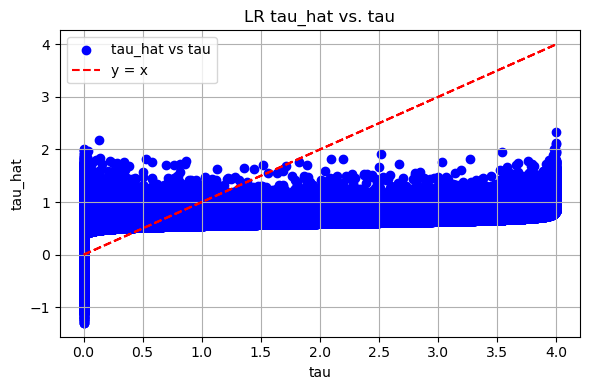

In [30]:
data_lr = data.copy()
data_lr['X1*Z'] = data_lr['X1'] * data_lr['Z'] #Setting interaction term
lr_xfit = data_lr[['X1', 'Z', 'X1*Z']]

lr = LinearRegression() #Fit linear regression
lr.fit(lr_xfit, data_lr['Y'])

bz = lr.coef_[1]
bzx = lr.coef_[2]

tau_hat_lr = bz + bzx*data['X1']


mse_lr, bias_lr, r2_lr = metrics.evaluate(tau, tau_hat_lr)

metrics.tau_plot(tau, tau_hat_lr, 'LR tau_hat vs. tau')

In [31]:
print(f'LR metrics:\nMse: {mse_lr}\nBias: {bias_lr}\nR2 {r2_lr}')

LR metrics:
Mse: 0.9226195409568307
Bias: 0.0030186706501952845
R2 0.16902634121190718


## X-Learner

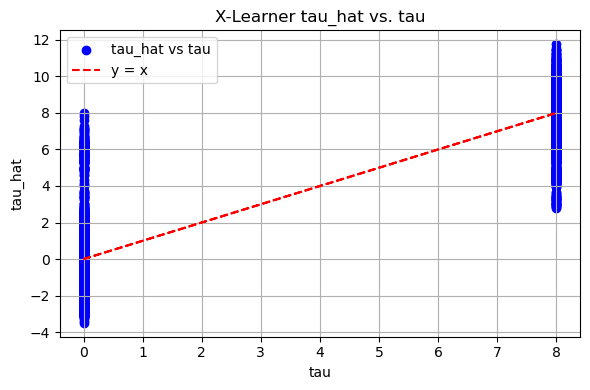

In [47]:
est = XLearner(models=RandomForestRegressor())
est.fit(y, T, X=X)
tau_hat_x = est.effect(X)
mse_x, bias_x, r2_x = metrics.evaluate(tau, tau_hat_x)
metrics.tau_plot(tau, tau_hat_x, 'X-Learner tau_hat vs. tau')

In [49]:
print(f'X-learner metrics:\nMse: {mse_x}\nBias: {bias_x}\nR2 {r2_x}')

X-learner metrics:
Mse: 0.5733008648783462
Bias: -0.022260879403289552
R2 0.9639053284162596


## S + T Learner

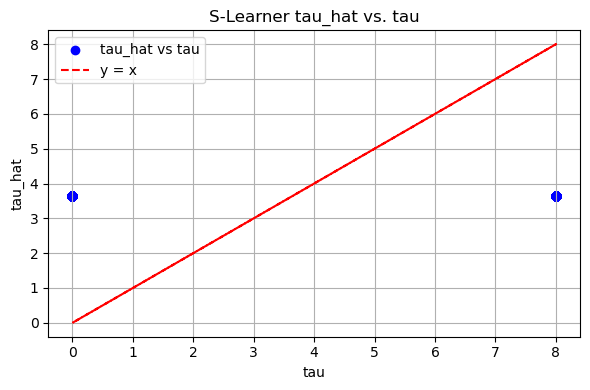

In [43]:
est = SLearner(overall_model=LinearRegression())
est.fit(y, T, X=X)
tau_hat_s = est.effect(X)

mse_s, bias_s, r2_s = metrics.evaluate(tau, tau_hat_s)
metrics.tau_plot(tau, tau_hat_s, 'S-Learner tau_hat vs. tau')

In [44]:
print(f'S-learner metrics:\nMse: {mse_s}\nBias: {bias_s}\nR2 {r2_s}')

S-learner metrics:
Mse: 15.883701734225436
Bias: 0.021141348713647635
R2 -2.8140115593044968e-05


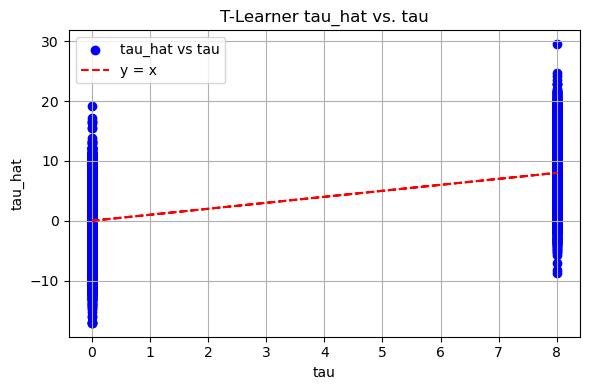

In [50]:
#est = TLearner(models=RandomForestRegressor())
#est.fit(y, T, X=X)
#tau_hat_t = est.effect(X)
tau_hat_t = Causal_TLearner(data, RandomForestRegressor())
mse_t, bias_t, r2_t = metrics.evaluate(tau, tau_hat_t)
metrics.tau_plot(tau, tau_hat_t, 'T-Learner tau_hat vs. tau')

In [51]:
print(f'T-learner metrics:\nMse: {mse_t}\nBias: {bias_t}\nR2 {r2_t}')

T-learner metrics:
Mse: 8.632602462200762
Bias: -0.04118655102648604
R2 0.4564966322661248


## DR-Learner

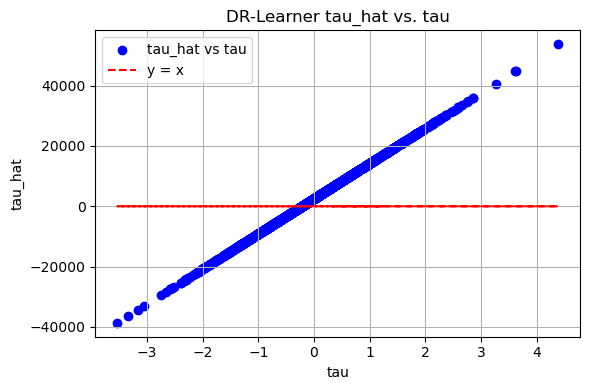

In [12]:
est = DRLearner()
est.fit(y, T, X=X, W=None)
tau_hat_dr = est.effect(X)

mse_dr, bias_dr, r2_dr = metrics.evaluate(tau, tau_hat_dr)
metrics.tau_plot(tau, tau_hat_dr, 'DR-Learner tau_hat vs. tau')

In [13]:
mse_dr

142838843.46498144

In [94]:
print(f'DR-learner metrics:\nMse: {mse_dr}\nBias: {bias_dr}\nR2 {r2_dr}')

DR-learner metrics:
Mse: 0.0008737148580995089
Bias: -0.0236642913062649
R2 0.9991282305285557


## Causal Forest

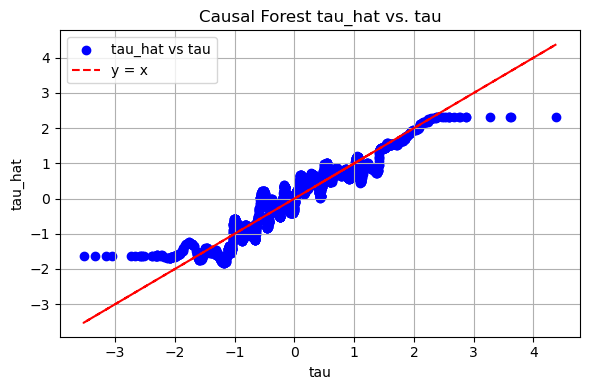

In [19]:
est = CausalForestDML(discrete_treatment=True)
est.fit(y, T, X=X, W=None)
tau_hat_cf = est.effect(X)

mse_cf, bias_cf, r2_cf = metrics.evaluate(tau, tau_hat_cf)
metrics.tau_plot(tau, tau_hat_cf, 'Causal Forest tau_hat vs. tau')

In [33]:
print(f'Causal Forest metrics:\nMse: {mse_cf}\nBias: {bias_cf}\nR2 {r2_cf}')

Causal Forest metrics:
Mse: 0.024863955548952404
Bias: 0.04439106423538852
R2 0.9784332303335951
